# Order Distribution Optimization  
*Making smarter decisions about how we handle order distribution*  

---

## Getting Started  
In this part, we are setting up our toolkit - importing all the Python packages we will need to work with the data, create visualizations, and run our calculations. Think of it like gathering all the ingredients before we start cooking.

##### 1.1 Libraries & Data Import

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

print("Libraries loaded!")

Libraries loaded!


## 2. Loading Our Data

Now we are bringing in the actual data we will be working with. We have three main files:

- **Orders**: Every customer's delivery request  
- **Trucks**: The vehicles we have available  
- **Distribution Centers**: The destinations for deliveries  

We will check that everything has loaded properly before moving forward.
ard.

In [6]:
# Loading datasets 

orders = pd.read_csv(r'C:\Users\sammy\Desktop\Affinity Labs Delivery Optimization Project\raw_data\orders.csv')
trucks = pd.read_csv(r'C:\Users\sammy\Desktop\Affinity Labs Delivery Optimization Project\raw_data\trucks.csv')
centres = pd.read_csv(r'C:\Users\sammy\Desktop\Affinity Labs Delivery Optimization Project\raw_data\centres.csv')

print("Data shapes:")
print(f"Orders: {orders.shape} | Trucks: {trucks.shape} | Centres: {centres.shape}")

Data shapes:
Orders: (526945, 11) | Trucks: (35, 5) | Centres: (5, 3)


## 3. Cleaning and Preparing the Data

Here we are preparing the data to ensure it is ready for analysis. We will:

- Fix dates and handle missing information in the orders  
- Ensure truck capacities are in the correct format  
- Clean up the location data  

This step is essential, much like preparing ingredients before cooking. It may not be glamorous, but it is crucial for accurate and effective analysis.
 work.

#### Orders Table

In [9]:
# ORDERS DATA TYPES & CLEANING 
print("Orders dtypes:")
print(orders.dtypes)  

# Convert dates
orders['lastModified'] = pd.to_datetime(orders['lastModified'], dayfirst=True)
orders['dateGenerated'] = pd.to_datetime(orders['dateGenerated'], dayfirst=True)

# Drop unnecessary column
orders.drop(columns=['Unnamed: 0'], inplace=True)

# Fill missing clientIds
orders['clientId'] = orders['clientId'].fillna('Unknown')

print("\nCleaned Orders dtypes:")
print(orders.dtypes)

Orders dtypes:
Unnamed: 0         int64
orderId           object
clientId          object
lastModified      object
status            object
truckKey          object
location          object
fee              float64
volume(kg)       float64
deliveryItem      object
dateGenerated     object
dtype: object

Cleaned Orders dtypes:
orderId                  object
clientId                 object
lastModified     datetime64[ns]
status                   object
truckKey                 object
location                 object
fee                     float64
volume(kg)              float64
deliveryItem             object
dateGenerated    datetime64[ns]
dtype: object


#### Trucks Table

In [11]:
# TRUCKS DATA TYPES & CLEANING
print("Trucks dtypes:")
print(trucks.dtypes)

# Convert data types
trucks['creationDate'] = pd.to_datetime(trucks['creationDate'])
trucks['volume(kg)'] = trucks['volume(kg)'].astype(float)

print("\nCleaned Trucks dtypes:")
print(trucks.dtypes)

Trucks dtypes:
creationDate    object
encodedKey      object
status          object
truckType       object
volume(kg)       int64
dtype: object

Cleaned Trucks dtypes:
creationDate    datetime64[ns]
encodedKey              object
status                  object
truckType               object
volume(kg)             float64
dtype: object


#### Centres Table

In [13]:
print("Centres dtypes:")
print(centres.dtypes)

# Convert date
centres['creationDate'] = pd.to_datetime(centres['creationDate'])

print("\nCleaned Centres dtypes:")
print(centres.dtypes)

Centres dtypes:
centreId         int64
location        object
creationDate    object
dtype: object

Cleaned Centres dtypes:
centreId                 int64
location                object
creationDate    datetime64[ns]
dtype: object


####

## 4. Checking Data Quality

Before we make any decisions, we need to ensure that we can trust our data. In this section, we are:

- Looking for duplicate records  
- Checking for missing values  
- Verifying that all data entries make sense  

This serves as our quality control checkpoint to maintain the integrity of our analysis.
point.

In [16]:
# Checking for missing values 
print("Missing Values:")
print("ORDERS:\n", orders.isnull().sum())
print("\nTRUCKS:\n", trucks.isnull().sum())
print("\nCENTRES:\n", centres.isnull().sum())

# checking for duplicates
print("\nDuplicates:")
print(f"Orders: {orders.duplicated().sum()}")
print(f"Trucks: {trucks.duplicated().sum()}") 
print(f"Centres: {centres.duplicated().sum()}")

Missing Values:
ORDERS:
 orderId               0
clientId              0
lastModified          0
status                0
truckKey         310775
location              0
fee                   0
volume(kg)            0
deliveryItem          0
dateGenerated         0
dtype: int64

TRUCKS:
 creationDate    0
encodedKey      0
status          0
truckType       0
volume(kg)      0
dtype: int64

CENTRES:
 centreId        0
location        0
creationDate    0
dtype: int64

Duplicates:
Orders: 0
Trucks: 0
Centres: 0


#### Saving Transformed Data

In [18]:
# PENDING ORDERS sub
pending_orders = orders[orders['status'] == 'PENDING'].copy()
print(f"Pending orders: {len(pending_orders):,}")

os.makedirs('transformed_data', exist_ok=True)

transformed_data = {
    'orders': orders,
    'trucks': trucks,
    'centres': centres,
    'pending_orders': pending_orders  
}

for name, df in transformed_data.items():
    df.to_csv(f'transformed_data/{name}.csv', index=False)

print("Saved to /transformed_data:")
print("- orders.csv")
print("- trucks.csv")
print("- centres.csv")
print("- pending_orders.csv")

Pending orders: 310,775
Saved to /transformed_data:
- orders.csv
- trucks.csv
- centres.csv
- pending_orders.csv


####

# PART 2

## 5. Setting Up the Optimization

Now we are defining the rules of our optimization:

- How full should our trucks ideally be? (85%)  
- What is the absolute maximum we can load? (90%)  

We are also filtering to include only active trucks and pending orders, as there is no need to consider resources that are not available for use.
 use.

In [22]:
active_trucks = trucks[trucks['status'] == 'ACTIVE'].copy()
pending_orders = orders[orders['status'] == 'PENDING'].copy()

print(f"Active trucks: {len(active_trucks)}")
print(f"Pending orders: {len(pending_orders):,}")
print(f"Total volume: {pending_orders['volume(kg)'].sum():,} kg")

Active trucks: 30
Pending orders: 310,775
Total volume: 26,882,387.486999992 kg


In [23]:
CONFIG = {
    'TRUCK_CAPACITIES': {
        'REEFER_TRUCK': 20000,  # kg
        'BOX_TRUCK': 15000
    },
    'TARGET_UTILIZATION': 0.85,  # 85% ideal
    'MAX_UTILIZATION': 0.90      # Absolute max
}

In [24]:
def calculate_realistic_capacity(trucks_df):
    capacity = {}
    for truck_type, vol in CONFIG['TRUCK_CAPACITIES'].items():
        count = len(trucks_df[trucks_df['truckType'] == truck_type])
        capacity[truck_type] = {
            'trucks_available': count,
            'target_kg': count * vol * CONFIG['TARGET_UTILIZATION'],
            'max_kg': count * vol * CONFIG['MAX_UTILIZATION']
        }
    return pd.DataFrame(capacity).T

capacity_report = calculate_realistic_capacity(active_trucks)
print("REALISTIC CAPACITY (85% TARGET | 90% MAX)")
print(capacity_report)
print(f"\nTOTAL TARGET CAPACITY: {capacity_report['target_kg'].sum():,.0f} kg")
print(f"TOTAL MAX CAPACITY: {capacity_report['max_kg'].sum():,.0f} kg")

REALISTIC CAPACITY (85% TARGET | 90% MAX)
              trucks_available  target_kg    max_kg
REEFER_TRUCK               5.0    85000.0   90000.0
BOX_TRUCK                 25.0   318750.0  337500.0

TOTAL TARGET CAPACITY: 403,750 kg
TOTAL MAX CAPACITY: 427,500 kg


## 6. The Optimization Process

This is where the core of our solution takes place. Our algorithm will:

1. Sort the orders from heaviest to lightest  
2. Fill each truck until it reaches the ideal capacity threshold  
3. Move on to the next truck once the current one is considered full  

We will also track how efficiently each truck is utilized throughout the process.
e way.

In [26]:
# Order Assignment Algorithm
def optimize_furniture_delivery(orders_df, trucks_df):
    
    # Sort by largest items first 
    orders = orders_df.sort_values('volume(kg)', ascending=False).copy()
    
    # Trucks Prep
    trucks = trucks_df.copy()
    trucks['target_cap'] = trucks['volume(kg)'] * CONFIG['TARGET_UTILIZATION']
    trucks['max_cap'] = trucks['volume(kg)'] * CONFIG['MAX_UTILIZATION']
    
    assignments = []
    order_indices = orders.index.tolist() 
    
    for _, truck in trucks.iterrows():
        batch = []
        current_load = 0
        
        
        for idx in order_indices[:]: 
            order = orders.loc[idx]
            proposed_load = current_load + order['volume(kg)']
            
            if proposed_load <= truck['max_cap']:
                batch.append(idx)
                current_load = proposed_load
                
                # Stop if we hit target (YOUR original break condition)
                if current_load >= truck['target_cap']:
                    break
        
        if batch:
            # Calculate utilization 
            utilization = current_load / truck['volume(kg)']
            assignments.append({
                'truck_id': truck['encodedKey'],
                'truck_type': truck['truckType'],
                'orders': len(batch),
                'total_kg': current_load,
                'utilization': utilization,
                'status': 'OPTIMAL' if utilization >= 0.85 else 'UNDERUTILIZED'
            })
            
            # Remove assigned orders 
            order_indices = [x for x in order_indices if x not in batch]
    
    # Return results 
    remaining_orders = orders.loc[order_indices]
    return pd.DataFrame(assignments), remaining_orders

## 7. Analyzing the Results

This section focuses on evaluating the performance of the optimization. The analysis includes:

- The number of orders that were fulfilled  
- The efficiency of truck usage  
- The volume and details of remaining backlog  

Charts and visuals provide a quick overview of key trends and areas that may require further attention.
ention.
glance.


In [28]:
assignments, backlog = optimize_furniture_delivery(pending_orders, active_trucks)


print(f"Trucks used: {len(assignments)}")
print(f"Orders allocated: {assignments['orders'].sum():,}")
print(f"Avg utilization: {assignments['utilization'].mean():.1%}")
print(f"Backlog remaining: {len(backlog):,}")

Trucks used: 30
Orders allocated: 1,060
Avg utilization: 86.1%
Backlog remaining: 309,715


#### Visualization:

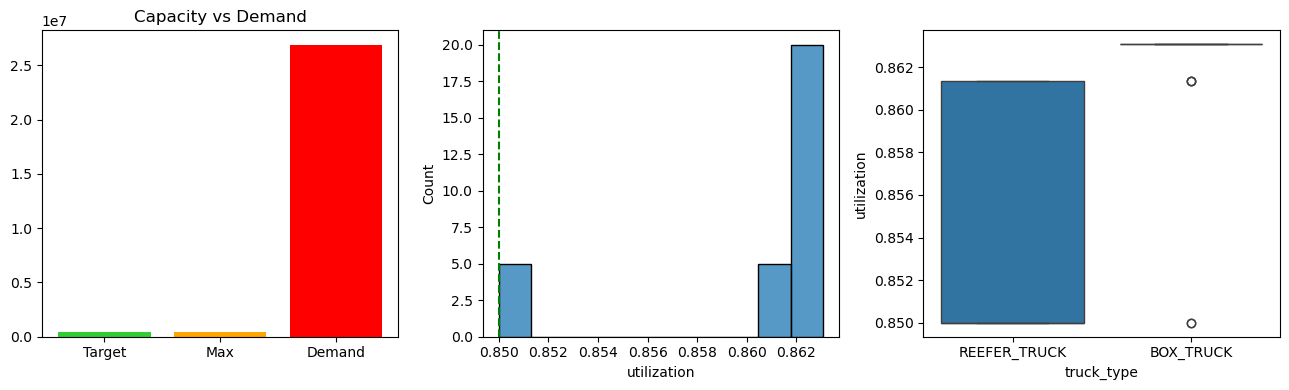

In [30]:
# CAPACITY PLOTS
plt.figure(figsize=(13, 4))

# Plot 1: Capacity vs Demand
plt.subplot(1, 3, 1)
plt.bar(['Target', 'Max', 'Demand'], 
        [capacity_report['target_kg'].sum(), 
         capacity_report['max_kg'].sum(), 
         pending_orders['volume(kg)'].sum()],
        color=['limegreen', 'orange', 'red'])
plt.title("Capacity vs Demand")

# Plot 2: Utilization Histogram
plt.subplot(1, 3, 2)
sns.histplot(assignments['utilization'], bins=10)
plt.axvline(0.85, color='green', linestyle='--')

# Plot 3: Truck Type Performance
plt.subplot(1, 3, 3)
sns.boxplot(data=assignments, x='truck_type', y='utilization')

plt.tight_layout()
plt.show()

## 8. Saving Our Work

This step involves exporting two essential files:

1. The optimized truck assignments  
2. The list of orders that could not be fulfilled  

These outputs can be shared with the operations team for further review and action.


In [32]:
# EXPORTING FILES...
os.makedirs('outputs', exist_ok=True)

# EXPORTING FILES...
assignments.to_csv('outputs/optimized_assignments.csv', index=False)
backlog.to_csv('outputs/remaining_backlog.csv', index=False)

print("\nSaved files:")
print("- outputs/optimized_assignments.csv")
print("- outputs/remaining_backlog.csv")


Saved files:
- outputs/optimized_assignments.csv
- outputs/remaining_backlog.csv


In [33]:
# Evidence from the analysis

print(f"CAPACITY ANALYSIS:\n"
      f"- Current monthly capacity (85% util): {capacity_report['target_kg'].sum():,.0f} kg\n"
      f"- Pending orders: {pending_orders['volume(kg)'].sum():,.0f} kg\n"
      f"- DEFICIT: {pending_orders['volume(kg)'].sum() - capacity_report['target_kg'].sum():,.0f} kg")

CAPACITY ANALYSIS:
- Current monthly capacity (85% util): 403,750 kg
- Pending orders: 26,882,387 kg
- DEFICIT: 26,478,637 kg


####

# PART 3

## 9. Fleet Expansion Analysis

Now that it is clear the current capacity is insufficient, this section explores how many additional trucks would be required to fulfill all pending orders.

**Objectives:**
- Calculate the shortfall in capacity
- Simulate multiple fleet expansion scenarios
- Compare different approaches (adding box trucks, reefer trucks, or a combination)

**Key Questions Addressed:**
- How many additional box trucks would be required if only those are added?
- What would the requirement be if only reefer trucks are added?
- What approach provides the most balanced and cost-effective solution?
ed approach?

In [37]:
# TRUCK FLEET EXPANSION CALCULATOR

# Inputs from  analysis
deficit_kg = pending_orders['volume(kg)'].sum() - capacity_report['target_kg'].sum()
current_box_trucks = len(active_trucks[active_trucks['truckType'] == 'BOX_TRUCK'])
current_reefers = len(active_trucks[active_trucks['truckType'] == 'REEFER_TRUCK'])

# Truck specs
TRUCK_SPECS = {
    'REEFER_TRUCK': {
        'capacity_kg': 20000,
        'utilization': 0.85,
        'trips_per_month': 4
    },
    'BOX_TRUCK': {
        'capacity_kg': 15000,
        'utilization': 0.85,
        'trips_per_month': 4
    }
}

# monthly capacity per truck
def monthly_capacity(truck_type):
    spec = TRUCK_SPECS[truck_type]
    return spec['capacity_kg'] * spec['utilization'] * spec['trips_per_month']

# trucks needed for different scenarios
def calculate_fleet_options(deficit):
    options = {}
    
    # Box trucks only
    options['box_only'] = {
        'box_trucks': int(deficit / monthly_capacity('BOX_TRUCK')),
        'reefers': 0
    }
    
    # Reefers only
    options['reefer_only'] = {
        'box_trucks': 0,
        'reefers': int(deficit / monthly_capacity('REEFER_TRUCK'))
    }
    
    # Balanced fleet (20% reefers, 80% box trucks)
    balanced_capacity = (0.2 * monthly_capacity('REEFER_TRUCK')) + (0.8 * monthly_capacity('BOX_TRUCK'))
    total_trucks = int(deficit / balanced_capacity)
    options['balanced'] = {
        'box_trucks': int(total_trucks * 0.8),
        'reefers': int(total_trucks * 0.2)
    }
    
    return options

# To Generate options
fleet_options = calculate_fleet_options(deficit_kg)



In [38]:
# RESULTS

print("\nFLEET EXPANSION OPTIONS TO COVER DEFICIT:")
print(f"Current Deficit: {deficit_kg:,.0f} kg/month")
print(f"Current Fleet: {current_box_trucks} box trucks + {current_reefers} reefers\n")

print("1. Box Trucks Only Solution:")
print(f"Add {fleet_options['box_only']['box_trucks']:,} box trucks")
print(f"Total box trucks: {current_box_trucks + fleet_options['box_only']['box_trucks']:,}")
print(f"Monthly capacity added: {fleet_options['box_only']['box_trucks'] * monthly_capacity('BOX_TRUCK'):,.0f} kg\n")

print("2. Reefers Only Solution:")
print(f"Add {fleet_options['reefer_only']['reefers']:,} reefers")
print(f"Total reefers: {current_reefers + fleet_options['reefer_only']['reefers']:,}")
print(f"Monthly capacity added: {fleet_options['reefer_only']['reefers'] * monthly_capacity('REEFER_TRUCK'):,.0f} kg\n")

print("3. Balanced Fleet Solution:")
print(f"Add {fleet_options['balanced']['box_trucks']:,} box trucks and {fleet_options['balanced']['reefers']:,} reefers")
print(f"Total fleet: {current_box_trucks + fleet_options['balanced']['box_trucks']:,} box trucks + {current_reefers + fleet_options['balanced']['reefers']:,} reefers")
print(f"Monthly capacity added: {(fleet_options['balanced']['box_trucks'] * monthly_capacity('BOX_TRUCK')) + (fleet_options['balanced']['reefers'] * monthly_capacity('REEFER_TRUCK')):,.0f} kg")




FLEET EXPANSION OPTIONS TO COVER DEFICIT:
Current Deficit: 26,478,637 kg/month
Current Fleet: 25 box trucks + 5 reefers

1. Box Trucks Only Solution:
Add 519 box trucks
Total box trucks: 544
Monthly capacity added: 26,469,000 kg

2. Reefers Only Solution:
Add 389 reefers
Total reefers: 394
Monthly capacity added: 26,452,000 kg

3. Balanced Fleet Solution:
Add 388 box trucks and 97 reefers
Total fleet: 413 box trucks + 102 reefers
Monthly capacity added: 26,384,000 kg


## 10. Visualizing Fleet Options

Charts allow us to clearly visualize the tradeoffs between different fleet expansion strategies:

**Fleet Expansion Options**
- **Left:** Number of additional trucks required for each strategy
- **Right:** Additional capacity provided by each fleet option

**Key Observations:**
- Adding only box trucks requires more vehicles, but it may be a more cost-effective option.
- Reefer trucks offer more capacity per vehicle but come at a higher cost.
- The balanced approach provides flexibility, combining cost-effectiveness and capacity.
flexibility

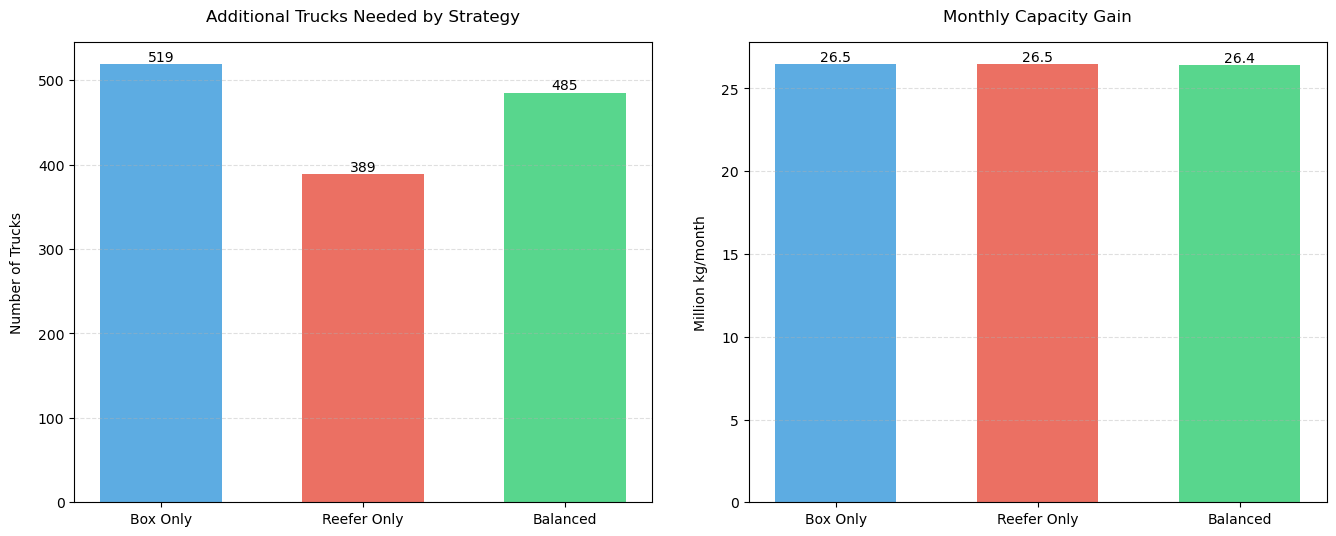

In [40]:
# Visualization 

plt.figure(figsize=(14, 6))

# Data preparation
strategies = ['Box Only', 'Reefer Only', 'Balanced']
truck_counts = [
    fleet_options['box_only']['box_trucks'],
    fleet_options['reefer_only']['reefers'],
    fleet_options['balanced']['box_trucks'] + fleet_options['balanced']['reefers']
]

# monthly capacities (using original 85% util)
box_capacity = 15000 * 0.85 * 4  # kg/month
reefer_capacity = 20000 * 0.85 * 4
capacity_gains = [
    fleet_options['box_only']['box_trucks'] * box_capacity / 1000000,  # in million kg
    fleet_options['reefer_only']['reefers'] * reefer_capacity / 1000000,
    (fleet_options['balanced']['box_trucks'] * box_capacity + 
     fleet_options['balanced']['reefers'] * reefer_capacity) / 1000000
]

# Chart 1: Trucks Needed 
ax1 = plt.subplot(1, 2, 1)
bars1 = ax1.bar(strategies, truck_counts, 
               color=['#3498db', '#e74c3c', '#2ecc71'],  
               width=0.6, alpha=0.8)
ax1.set_title("Additional Trucks Needed by Strategy", pad=15)
ax1.set_ylabel("Number of Trucks", labelpad=10)
ax1.grid(axis='y', linestyle='--', alpha=0.4)

# Chart 2: Capacity Gain
ax2 = plt.subplot(1, 2, 2)
bars2 = ax2.bar(strategies, capacity_gains,
               color=['#3498db', '#e74c3c', '#2ecc71'],  
               width=0.6, alpha=0.8)
ax2.set_title("Monthly Capacity Gain", pad=15)
ax2.set_ylabel("Million kg/month", labelpad=10)
ax2.grid(axis='y', linestyle='--', alpha=0.4)

# value labels on both charts
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        bar.axes.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:,.1f}' if bars == bars2 else f'{int(height):,}',
                     ha='center', va='bottom')

plt.tight_layout(pad=3)
plt.show()

####

## 11. The Simulation

We will simulate the process of clearing the backlog with the expanded fleet.

**How the Simulation Works:**
- Assume the new trucks have been added to the fleet
- Process orders on a month-by-month basis
- Track the progress until we have shipped the 9M kg backlog
g 9M kg shipped

In [43]:
# Loading  data from the transformed data folder
orders = pd.read_csv('transformed_data/orders.csv', dtype={'orderId': str}, low_memory=False)
pending_orders = pd.read_csv('transformed_data/pending_orders.csv', dtype={'orderId': str}, low_memory=False)
pending_orders['dateGenerated'] = pd.to_datetime(pending_orders['dateGenerated'])


#### # FLEET EXPANSION CONFIGURATION

In [45]:
# Current fleet capacity (from original analysis)
current_monthly_capacity = 403750  # kg (30 trucks)

# Proposed expansion (388 box + 97 reefers)
added_box_trucks = 388
added_reefer_trucks = 97

# Capacity calculations
box_truck_capacity = 15000 * 0.85  # 12,750 kg/month
reefer_truck_capacity = 20000 * 0.85  # 17,000 kg/month

# New total capacity
expanded_capacity = (current_monthly_capacity + 
                    (added_box_trucks * box_truck_capacity) + 
                    (added_reefer_trucks * reefer_truck_capacity))

print(f"Original monthly capacity: {current_monthly_capacity/1e6:.2f}M kg")
print(f"Expanded monthly capacity: {expanded_capacity/1e6:.2f}M kg")

Original monthly capacity: 0.40M kg
Expanded monthly capacity: 7.00M kg


#### # SIMULATION FUNCTION

In [47]:
def simulate_with_expansion(backlog, monthly_capacity, max_months=12):
    backlog = backlog.copy()
    monthly_results = []

    for month in range(1, max_months + 1):
        # Calculate revenue density (fee per kg)
        backlog['density'] = backlog['fee'] / backlog['volume(kg)']

        # Prioritize by density and order date
        backlog = backlog.sort_values(['density', 'dateGenerated'], ascending=[False, True])

        # Fulfill orders
        fulfilled = []
        capacity_used = 0

        for idx, order in backlog.iterrows():
            if capacity_used + order['volume(kg)'] <= monthly_capacity:
                fulfilled.append(idx)
                capacity_used += order['volume(kg)']
            else:
                break  # Stop processing once monthly capacity is reached

        # Track fulfilled and update backlog
        fulfilled_orders = backlog.loc[fulfilled]
        backlog = backlog.drop(fulfilled)

        # Record monthly results
        monthly_results.append({
            'month': month,
            'fulfilled_kg': capacity_used,
            'remaining_kg': backlog['volume(kg)'].sum(),
            'utilization': capacity_used / monthly_capacity,
            'orders_fulfilled': len(fulfilled_orders),
            'revenue_generated': fulfilled_orders['fee'].sum()
        })

        # Exit early if backlog is empty
        if backlog.empty:
            break

    return pd.DataFrame(monthly_results), backlog


results, final_backlog = simulate_with_expansion(
    pending_orders,
    monthly_capacity=expanded_capacity,
    max_months=12
)

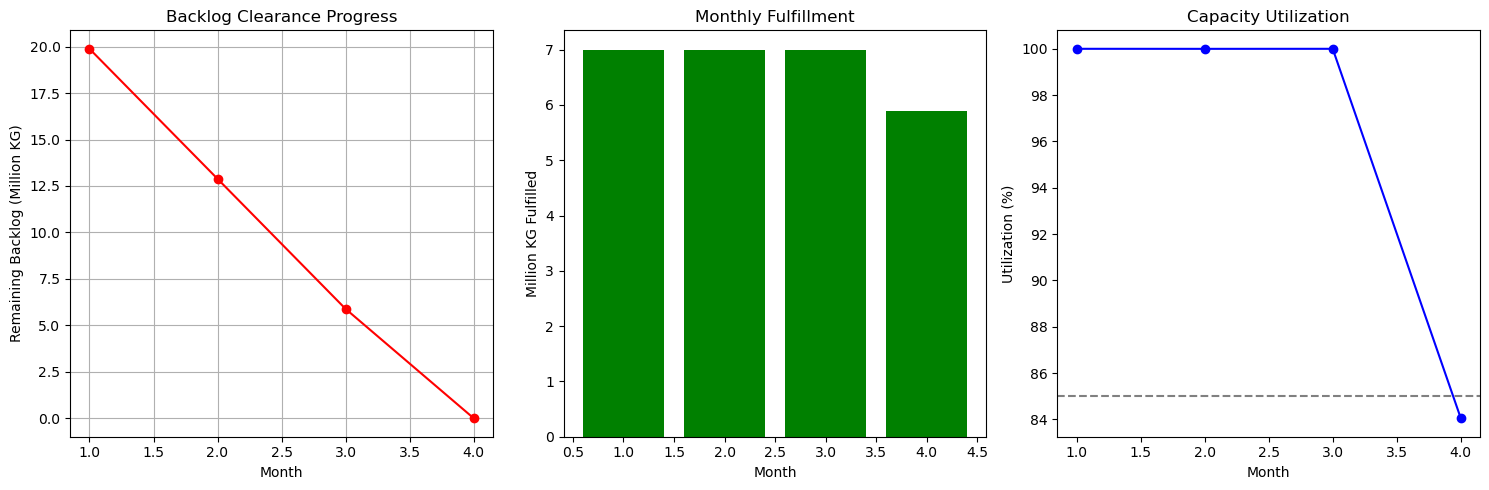


FINAL RESULTS:
- Initial backlog: 26.9M kg
- Fleet size: 413 box trucks + 102 reefers
- Monthly capacity: 7.0M kg
- Backlog cleared in: 4 months
- Total fulfilled: 26.9M kg
- Avg utilization: 96.0%
- Revenue generated: $513.6M
- Orders remaining: 0 (0.0%)


In [48]:
# VISUALIZATION

plt.figure(figsize=(15, 5))

# Backlog clearance progress
plt.subplot(1, 3, 1)
plt.plot(results['month'], results['remaining_kg']/1e6, marker='o', color='red')
plt.title('Backlog Clearance Progress')
plt.xlabel('Month')
plt.ylabel('Remaining Backlog (Million KG)')
plt.grid(True)

# Monthly fulfillment
plt.subplot(1, 3, 2)
plt.bar(results['month'], results['fulfilled_kg']/1e6, color='green')
plt.title('Monthly Fulfillment')
plt.xlabel('Month')
plt.ylabel('Million KG Fulfilled')

# Utilization
plt.subplot(1, 3, 3)
plt.plot(results['month'], results['utilization']*100, marker='o', color='blue')
plt.axhline(85, color='gray', linestyle='--')
plt.title('Capacity Utilization')
plt.xlabel('Month')
plt.ylabel('Utilization (%)')

plt.tight_layout()
plt.show()


# RESULTS

clearance_time = len(results)
total_fulfilled = results['fulfilled_kg'].sum()
initial_backlog = pending_orders['volume(kg)'].sum()

print(f"\nFINAL RESULTS:")
print(f"- Initial backlog: {initial_backlog/1e6:.1f}M kg")
print(f"- Fleet size: 413 box trucks + 102 reefers")
print(f"- Monthly capacity: {expanded_capacity/1e6:.1f}M kg")
print(f"- Backlog cleared in: {clearance_time} months")
print(f"- Total fulfilled: {total_fulfilled/1e6:.1f}M kg")
print(f"- Avg utilization: {results['utilization'].mean():.1%}")
print(f"- Revenue generated: ${results['revenue_generated'].sum()/1e6:.1f}M")
print(f"- Orders remaining: {len(final_backlog):,} ({(len(final_backlog)/len(pending_orders)*100):.1f}%)")

## 12. Simulation Insights

**What the numbers tell us:**

**Good News:**
- With the expanded fleet, the backlog could be cleared in 4 months
- The fleet would maintain a 96% average utilizion — very efficient!

**Considerations:**
- This assumes all new trucks arrive immediately
- Real-world factors (maintenance, delays) may add time


### 13. Actionable Long-Term Solutions  
These strategies aim to sustainably expand capacity, improve operational efficiency, and prevent future backlog issues.

---

**1. Expand Fleet Capacity Strategically**  
- Increase the number of box trucks, which are better suited for average order volumes and more cost-effective.  
- Use short-term leasing during peak periods (e.g., March) to handle demand surges without long-term overhead.

---

**2. Align Fleet Deployment with Regional Demand**  
- Prioritize truck allocation to high-volume hubs such as Accra and Tema, based on real-time demand patterns.  
- Monitor key metrics (e.g., fulfillment time, backlog levels) across delivery centers to guide continuous fleet adjustments.  
- Avoid shifting orders between regions unless supported by service-level data or capacity constraints.

---

**3. Improve Load Distribution Efficiency**  
- Enforce smarter order batching rules to reduce volume variability and optimize truck space usage.  
- Use historical data to guide more consistent load planning and routing efficiency.

---

**4. Strengthen Data Integrity and Planning Accuracy**  
- Prevent extreme overutilization by applying validation checks during truck assignment (e.g., utilization thresholds).  
- Standardize definitions for truck capacity and volume across all platforms to enable accurate, consistent planning and analysis.
